In [ ]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Load Data

In [2]:
data = pd.read_csv("datasets/final_df_PLEASE.csv")

data.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care


## Clean Data

In [3]:
# drop unnecessary columns
data = data.drop(columns=["Shipping Address State", "Survey ResponseID"])
data['Order Date'] = pd.to_datetime(data['Order Date'])

# remove null / NA values
data = data.dropna()

data.head()

,Order Date,Purchase Price Per Unit,Quantity,Title,ASIN/ISBN (Product Code),Category
0,2018-12-04,7.98,1,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,Electronics
1,2018-12-22,13.99,1,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,Electronics
3,2018-12-25,10.45,1,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,Kitchen & Dining
4,2018-12-25,10.00,1,Proraso Shaving Cream for Men,B00837ZOI0,Beauty & Personal Care
5,2019-02-18,10.99,1,Micro USB Cable Android Charger - Syncwire [2-...,B01GFB2E9M,Computer & Accessories


# Price Elasticity

In [ ]:
def calculate_quarterly_price_elasticity(data, category, top_n_products=50, lower_cap_percentile=0.05, upper_cap_percentile=0.95):
    # Filter data for the specified category
    category_data = data[data['Category'] == category]
    
    # Calculate total sales per product and get the top_n_products by sales volume
    top_products_by_sales = (
        category_data.groupby('Title')['Quantity'].sum()
        .nlargest(top_n_products)
        .index
    )
    category_data = category_data[category_data['Title'].isin(top_products_by_sales)]
    
    category_data['Order Date'] = pd.to_datetime(category_data['Order Date'])
    category_data = category_data.set_index('Order Date')
    
    elasticity_results = []

    # Calculating quarterly elasticity for each top-selling product
    for product in top_products_by_sales:
        product_data = category_data[category_data['Title'] == product]
        product_data = product_data.dropna(subset=['Purchase Price Per Unit', 'Quantity'])

        if product_data.empty:
            continue

        # Resample data to quarterly frequency
        quarterly_data = product_data.resample('QE').agg({
            'Purchase Price Per Unit': 'mean',
            'Quantity': 'sum'
        }).dropna()

        if quarterly_data.empty:
            continue

        # Calculate quarterly revenue for each product
        quarterly_data['Revenue'] = quarterly_data['Purchase Price Per Unit'] * quarterly_data['Quantity']

        # Reset index to make 'Order Date' a column in quarterly_data
        quarterly_data = quarterly_data.reset_index()

        # Calculate percentage changes
        quarterly_data['Price Change %'] = quarterly_data['Purchase Price Per Unit'].pct_change() * 100
        quarterly_data['Quantity Change %'] = quarterly_data['Quantity'].pct_change() * 100

        # Drop rows with NaN in change percentages
        quarterly_data = quarterly_data.dropna(subset=['Price Change %', 'Quantity Change %'])
        
        if quarterly_data.empty:
            continue

        # Calculate elasticity as Quantity Change % / Price Change %
        quarterly_data['Elasticity'] = quarterly_data.apply(
            lambda row: row['Quantity Change %'] / row['Price Change %'] if row['Price Change %'] != 0 else None,
            axis=1
        )

        # Forward-fill NaN values in Elasticity column with the last known value
        quarterly_data['Elasticity'] = quarterly_data['Elasticity'].ffill()
        # Add product and category columns
        quarterly_data['Title'] = product
        quarterly_data['Category'] = category

        # Append to results
        elasticity_results.append(quarterly_data[['Order Date', 'Title', 'Category', 'Elasticity', 'Revenue']])

    # Combine all product results into a single DataFrame
    elasticity_df = pd.concat(
    [df.dropna(axis=1, how='all')  # Drop columns that are entirely NA
     for df in elasticity_results if not df.empty and not df.dropna(axis=1, how='all').empty
    ], axis=0
    ).reset_index(drop=True) if elasticity_results else pd.DataFrame(columns=['Order Date', 'Title', 'Category', 'Elasticity', 'Revenue'])


    # Calculate the 5th and 95th percentiles for elasticity within this category
    if not elasticity_df.empty:
        lower_threshold = elasticity_df['Elasticity'].quantile(lower_cap_percentile)
        upper_threshold = elasticity_df['Elasticity'].quantile(upper_cap_percentile)

        # Cap elasticity values below the lower threshold and above the upper threshold
        elasticity_df['Elasticity'] = elasticity_df['Elasticity'].apply(lambda x: max(min(x, upper_threshold), lower_threshold))

    # Calculate the average elasticity and total revenue per quarter for this category
    category_avg_elasticity_df = elasticity_df.groupby('Order Date').agg({
        'Elasticity': 'mean',
        'Revenue': 'sum'
    }).reset_index()
    category_avg_elasticity_df['Category'] = category
    category_avg_elasticity_df.rename(columns={'Elasticity': 'Average Elasticity', 'Revenue': 'Total Revenue'}, inplace=True)

    return elasticity_df, category_avg_elasticity_df

# Example usage with data
categories = [
    'Electronics',
    'Grocery',
    'Home',
    'Health, Household & Personal Care',
    'Clothing, Shoes and Jewellery',
]

category_results = {}

# Calculate quarterly elasticities for each category
for category in categories:
    elasticity_df, category_avg_elasticity_df = calculate_quarterly_price_elasticity(data, category=category, top_n_products=50)
    category_results[category] = {
        'Elasticity DataFrame': elasticity_df,
        'Average Quarterly Elasticity DataFrame': category_avg_elasticity_df
    }

# To view the individual product elasticities, average elasticity, and total revenue for each category
for category, results in category_results.items():
    print(f"Category: {category}")
    print("Individual Product Elasticities:\n", results['Elasticity DataFrame'].head())
    print("Average Quarterly Elasticity and Total Revenue:\n", results['Average Quarterly Elasticity DataFrame'].head())

Category: Electronics
Individual Product Elasticities:
   Order Date                                              Title     Category  \
0 2018-06-30  Amazon Basics 36 Pack AAA High-Performance Alk...  Electronics   
1 2018-09-30  Amazon Basics 36 Pack AAA High-Performance Alk...  Electronics   
2 2018-12-31  Amazon Basics 36 Pack AAA High-Performance Alk...  Electronics   
3 2019-03-31  Amazon Basics 36 Pack AAA High-Performance Alk...  Electronics   
4 2019-06-30  Amazon Basics 36 Pack AAA High-Performance Alk...  Electronics   

   Elasticity  Revenue  
0   -1.694437   119.88  
1   13.320000    77.92  
2   24.350000   129.87  
3   11.526923    97.90  
4   42.915068   158.83  
Average Quarterly Elasticity and Total Revenue:
   Order Date  Average Elasticity  Total Revenue     Category
0 2018-06-30           -4.045728    3704.240418  Electronics
1 2018-09-30           16.833557    9028.270420  Electronics
2 2018-12-31           11.732572    6943.310089  Electronics
3 2019-03-31        

## Debugging

  Order Date  Avg Price per Unit  Total Quantity Sold  Price Change %  \
0 2020-06-30            8.636667                    3      -43.366120   
1 2020-09-30           15.500000                    2       79.467387   
2 2020-12-31           15.500000                    2        0.000000   
3 2021-03-31           15.500000                    6        0.000000   
4 2022-03-31           17.626667                    3       13.720430   
5 2022-06-30           23.233333                    3       31.807867   
6 2022-09-30           16.900000                    1      -27.259684   
7 2022-12-31           19.900000                    3       17.751479   

   Sales Change %  Elasticity  
0       50.000000   -1.152974  
1      -33.333333   -0.419459  
2        0.000000   -0.419459  
3      200.000000   -0.419459  
4      -50.000000   -3.644201  
5        0.000000    0.000000  
6      -66.666667    2.445614  
7      200.000000   11.266667  


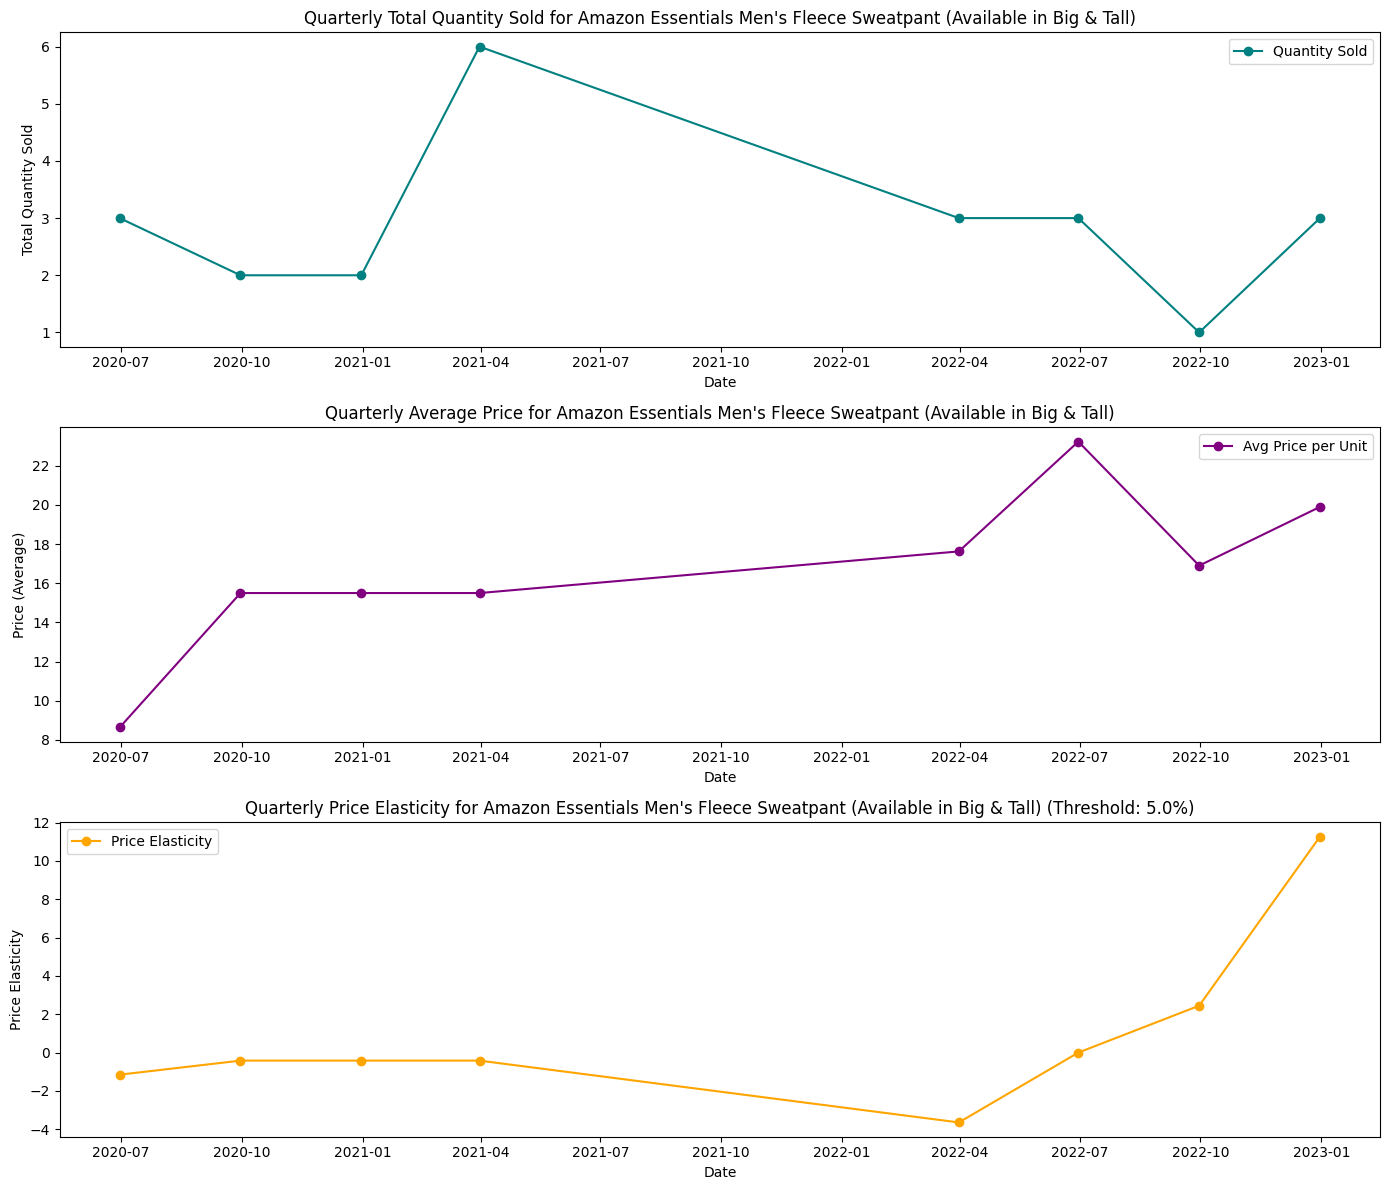

In [ ]:
# Define a minimum price change threshold
price_change_threshold = 5.0

# Filter data for the specific product
product_name = "Amazon Essentials Men's Fleece Sweatpant (Available in Big & Tall)"
product_data = data[data['Title'] == product_name].copy()

# Ensure 'Order Date' is in datetime format and set it as the index for resampling
product_data['Order Date'] = pd.to_datetime(product_data['Order Date'])
product_data = product_data.set_index('Order Date')

# Resample data to quarterly frequency and calculate mean price and total quantity sold per quarter
quarterly_data = product_data.resample('QE').agg({
    'Purchase Price Per Unit': 'mean',
    'Quantity': 'sum'
}).dropna()

# Calculate percentage changes from the previous quarter
quarterly_data['Price Change %'] = quarterly_data['Purchase Price Per Unit'].pct_change() * 100
quarterly_data['Sales Change %'] = quarterly_data['Quantity'].pct_change() * 100

# Calculate elasticity only if the absolute price change is above the threshold
quarterly_data['Elasticity'] = quarterly_data.apply(
    lambda row: row['Sales Change %'] / row['Price Change %'] 
    if abs(row['Price Change %']) >= price_change_threshold else None,
    axis=1
)
quarterly_data['Elasticity'] = quarterly_data['Elasticity'].ffill()

# Drop rows with NaN values resulting from percentage change calculations
quarterly_data = quarterly_data.dropna()

# Rename columns for clarity
quarterly_data = quarterly_data.rename(columns={
    'Purchase Price Per Unit': 'Avg Price per Unit',
    'Quantity': 'Total Quantity Sold'
})

# Reset index to use 'Order Date' as a column for plotting
quarterly_data.reset_index(inplace=True)

# Display the resulting table
print(quarterly_data)

# Plot the quantity, price, and elasticity over time
plt.figure(figsize=(14, 12))

# Plot Quantity Sold over time
plt.subplot(3, 1, 1)
plt.plot(quarterly_data['Order Date'], quarterly_data['Total Quantity Sold'], color='teal', marker='o', label='Quantity Sold')
plt.title(f"Quarterly Total Quantity Sold for {product_name}")
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()

# Plot Average Price per Unit over time
plt.subplot(3, 1, 2)
plt.plot(quarterly_data['Order Date'], quarterly_data['Avg Price per Unit'], color='purple', marker='o', label='Avg Price per Unit')
plt.title(f"Quarterly Average Price for {product_name}")
plt.xlabel('Date')
plt.ylabel('Price (Average)')
plt.legend()

# Plot Price Elasticity over time
plt.subplot(3, 1, 3)
plt.plot(quarterly_data['Order Date'], quarterly_data['Elasticity'], color='orange', marker='o', label='Price Elasticity')
plt.title(f"Quarterly Price Elasticity for {product_name} (Threshold: {price_change_threshold}%)")
plt.xlabel('Date')
plt.ylabel('Price Elasticity')
plt.legend()

plt.tight_layout()
plt.show()


## Plotting Elasticity Results 

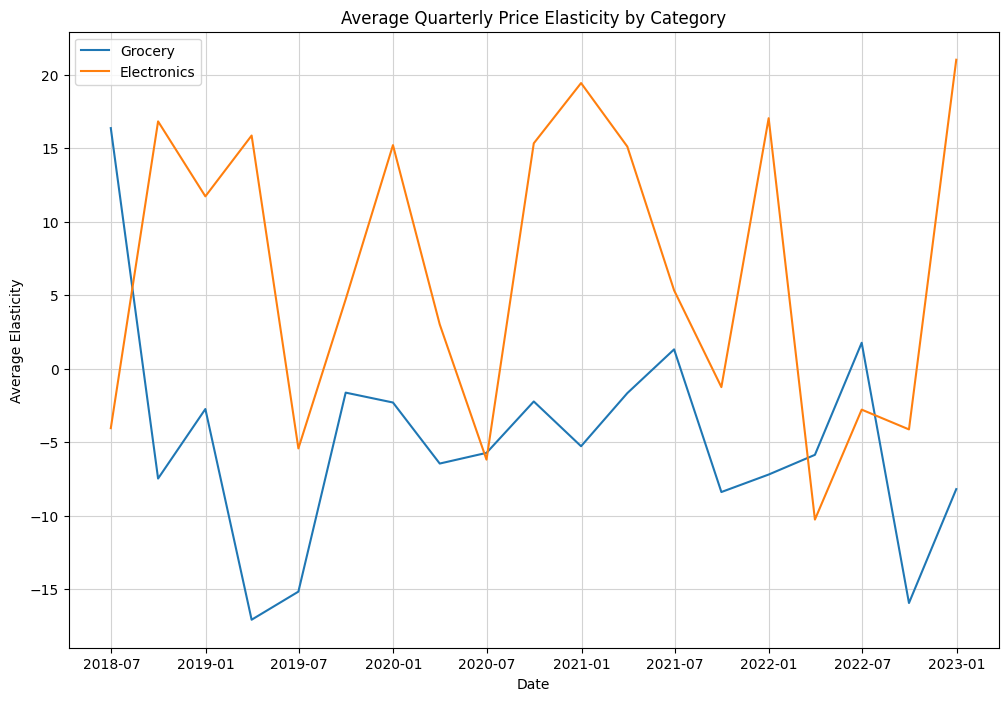

In [ ]:
# Combine elasticity data for each category into a single DataFrame
combined_elasticity_df = pd.concat(
    [results['Elasticity DataFrame'] for results in category_results.values()],
    axis=0
).reset_index(drop=True)

# Plotting average elasticity for each category over time
plt.figure(figsize=(12, 8))

interested_categories = ['Grocery', 'Electronics']

# Group by 'Order Date' and 'Category' to calculate the average elasticity over time
for category in interested_categories:
    avg_elasticity_over_time = (
        combined_elasticity_df[combined_elasticity_df['Category'] == category]
        .groupby('Order Date')['Elasticity']
        .mean()
    )
    if not avg_elasticity_over_time.empty:
        plt.plot(avg_elasticity_over_time.index, avg_elasticity_over_time, label=category)

plt.title('Average Quarterly Price Elasticity by Category')
plt.xlabel('Date')
plt.ylabel('Average Elasticity')
plt.grid(True, color = 'lightgrey')
plt.legend()
plt.show()

## Optimal elasticity values

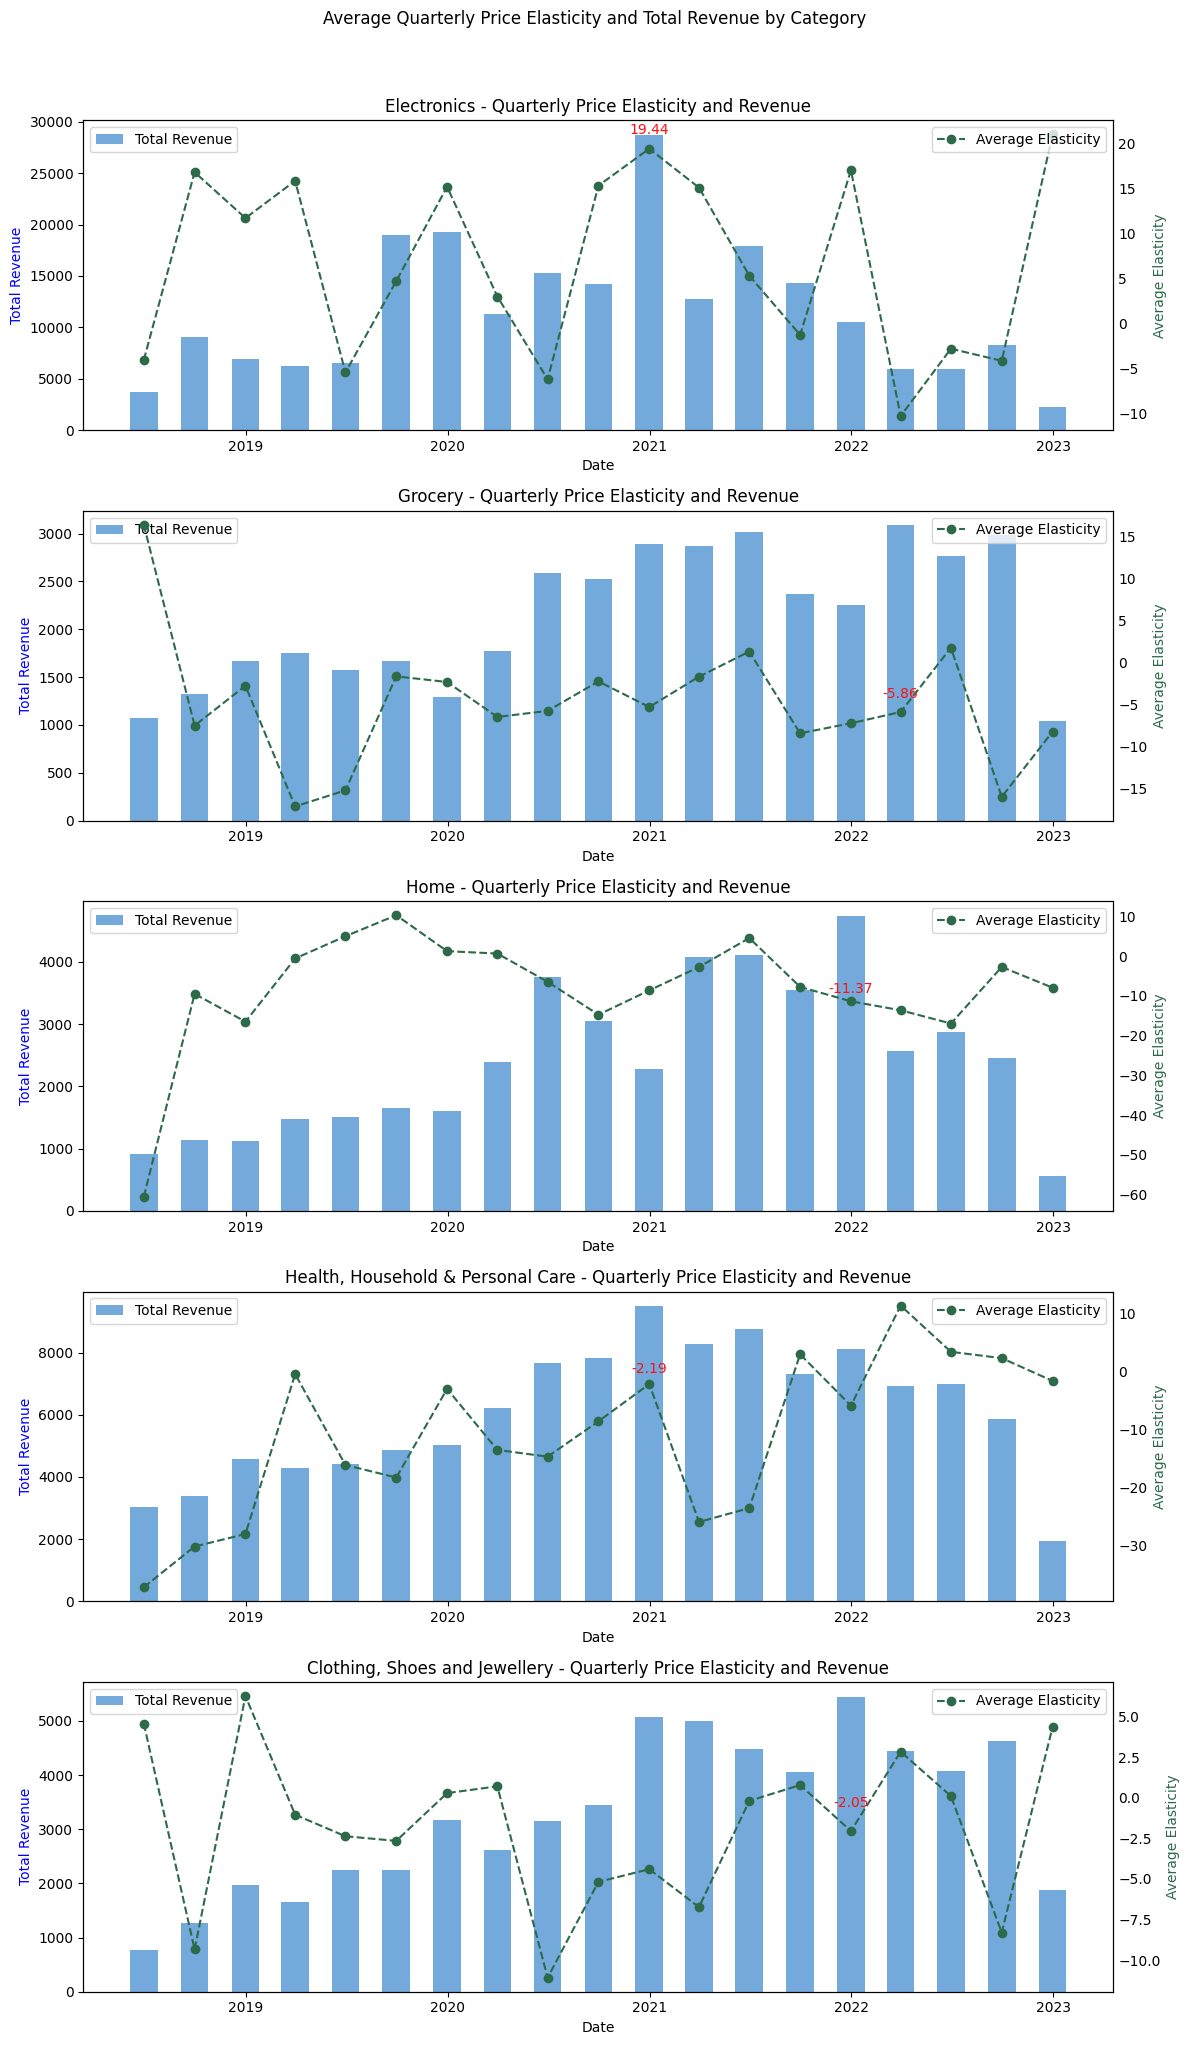

In [ ]:
# Define a nicer color palette
revenue_color = '#5A9BD5' 
elasticity_color = '#2C6A4A'
highlight_color = '#FF0F0F'

# Set up figure with subplots, one for each category, without sharing the x-axis
fig, axs = plt.subplots(len(categories), 1, figsize=(12, len(categories) * 4))

for idx, category in enumerate(categories):
    avg_elasticity_df = category_results[category]['Average Quarterly Elasticity DataFrame']

    # Plot Total Revenue as a wider bar plot with a more visible color
    ax = axs[idx]
    ax.bar(avg_elasticity_df['Order Date'], avg_elasticity_df['Total Revenue'], label="Total Revenue", 
           color=revenue_color, alpha=0.85, width=50)
    ax.set_ylabel("Total Revenue", color='blue')
    ax.set_title(f'{category} - Quarterly Price Elasticity and Revenue')

    # Create a secondary y-axis for Average Elasticity
    ax2 = ax.twinx()
    ax2.plot(avg_elasticity_df['Order Date'], avg_elasticity_df['Average Elasticity'], 
             label="Average Elasticity", color=elasticity_color, marker='o', markersize=6, linestyle='--')
    ax2.set_ylabel("Average Elasticity", color=elasticity_color)

    # Identify max revenue points and label corresponding elasticity
    max_revenue_idx = avg_elasticity_df['Total Revenue'].idxmax()
    max_revenue_date = avg_elasticity_df.loc[max_revenue_idx, 'Order Date']
    max_elasticity_value = avg_elasticity_df.loc[max_revenue_idx, 'Average Elasticity']
    
    # Annotate elasticity at max revenue point with only the value
    ax2.annotate(f'{max_elasticity_value:.2f}', 
                 xy=(max_revenue_date, max_elasticity_value), 
                 xytext=(max_revenue_date, max_elasticity_value + 1.3), 
                 ha='center', va='bottom', color=highlight_color)

    ax2.tick_params(axis='y', which='both', length=0)

    # Add legends for readability
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

    # Set x-axis label for each subplot
    ax.set_xlabel('Date')

# Set the main title for the whole figure
fig.suptitle("Average Quarterly Price Elasticity and Total Revenue by Category", y=1.02)
fig.tight_layout()
plt.show()


In [ ]:
# Iterate through each category to find the optimal elasticity that maximizes revenue
optimal_elasticities = {}

for category in categories:
    avg_elasticity_df = category_results[category]['Average Quarterly Elasticity DataFrame']

    # Calculate the optimal elasticity point that maximizes revenue
    max_revenue_idx = avg_elasticity_df['Total Revenue'].idxmax()  # Index of max revenue
    max_revenue_date = avg_elasticity_df.loc[max_revenue_idx, 'Order Date']
    max_revenue = avg_elasticity_df.loc[max_revenue_idx, 'Total Revenue']
    optimal_elasticity_value = avg_elasticity_df.loc[max_revenue_idx, 'Average Elasticity']

    optimal_elasticities[category] = {
        'Date': max_revenue_date,
        'Max Revenue': max_revenue,
        'Elasticity at Max Revenue': optimal_elasticity_value
    }

# Print optimal elasticity values for each category
for category, values in optimal_elasticities.items():
    print(f"Category: {category}")
    print(f"  Date: {values['Date']}")
    print(f"  Max Revenue: {values['Max Revenue']:.2f}")
    print(f"  Elasticity at Max Revenue: {values['Elasticity at Max Revenue']:.2f}\n")


Category: Electronics
  Date: 2020-12-31 00:00:00
  Max Revenue: 28697.13
  Elasticity at Max Revenue: 19.44

Category: Grocery
  Date: 2022-03-31 00:00:00
  Max Revenue: 3084.36
  Elasticity at Max Revenue: -5.86

Category: Home
  Date: 2021-12-31 00:00:00
  Max Revenue: 4739.34
  Elasticity at Max Revenue: -11.37

Category: Health, Household & Personal Care
  Date: 2020-12-31 00:00:00
  Max Revenue: 9491.11
  Elasticity at Max Revenue: -2.19

Category: Clothing, Shoes and Jewellery
  Date: 2021-12-31 00:00:00
  Max Revenue: 5445.79
  Elasticity at Max Revenue: -2.05



## Data Preprocessing

In [ ]:
categories = data['Category'].unique()
elasticity_dfs = []

# Loop through each category and calculate elasticity
for category in categories:
    elasticity_df, category_avg_elasticity_df = calculate_quarterly_price_elasticity(data, category=category, top_n_products=50)
    # append the result to the list
    elasticity_dfs.append(elasticity_df)

# Concatenate all individual elasticity into one df
all_elasticity_df = pd.concat(elasticity_dfs, ignore_index=True)

# Merge elasticity with dataset
prices_df = pd.merge(data, all_elasticity_df, on=['Order Date', 'Title', 'Category'], how='left')
prices_df = prices_df.dropna()

# Calulate demand by summing up the quantity sold for each unique product code
prices_df["Demand"] = prices_df.groupby(['ASIN/ISBN (Product Code)'])['Quantity'].transform('sum')

# Identify groups with exactly two items and set competition price to the other item in the pair
two_item_groups = prices_df.groupby(['Title', 'ASIN/ISBN (Product Code)']).filter(lambda x: len(x) == 2)
prices_df.loc[two_item_groups.index, 'Competition Price'] = two_item_groups['Purchase Price Per Unit'].iloc[::-1].values

# For groups with more than two items, set the competition price to the median of the group's prices (excluding self)
prices_df['Competition Price'] = prices_df.groupby(['Title', 'ASIN/ISBN (Product Code)'])['Purchase Price Per Unit'].transform(
    lambda x: x.map(lambda price: x[x != price].median() if len(x[x != price]) > 0 else price)
)

# Round to 2 dp
prices_df['Competition Price'] = prices_df['Competition Price'].round(2)

# Remove gift cards 
prices_df = prices_df[prices_df['Category'] != 'Gift Cards']

# Remove items that are entirely unique 
prices_df = prices_df.groupby('ASIN/ISBN (Product Code)').filter(lambda x: len(x) > 1).sort_values('ASIN/ISBN (Product Code)')
prices_df


,Order Date,Purchase Price Per Unit,Quantity,Title,ASIN/ISBN (Product Code),Category,Elasticity,Revenue,Demand,Competition Price
685896,2022-03-31,12.40,1,Where the Crawdads Sing,0735219095,Books,-2.749311,12.40000,2,9.59
193044,2019-12-31,9.59,1,Where the Crawdads Sing,0735219095,Books,0.506625,50.12000,2,12.40
170242,2020-12-31,22.96,1,D&D Player’s Handbook (Dungeons & Dragons Core...,0786965606,Toys and Games,-21.909091,183.68000,2,29.97
1026396,2018-09-30,29.97,1,D&D Player’s Handbook (Dungeons & Dragons Core...,0786965606,Toys and Games,2.229508,89.91000,2,22.96
170244,2020-12-31,25.00,1,D&D Dungeon Master’s Guide (Dungeons & Dragons...,0786965622,Toys and Games,66.416667,135.46250,2,26.94
...,...,...,...,...,...,...,...,...,...,...
1276303,2020-09-30,0.98,1,"Dole Bananas, 2 lb Bag",B07ZLFPXHC,Grocery,-39.200000,26.62875,5,1.23
972008,2021-12-31,1.29,1,"Dole Bananas, 2 lb Bag",B07ZLFPXHC,Grocery,0.312513,34.02000,5,0.98
1030194,2021-12-31,1.29,1,"Dole Bananas, 2 lb Bag",B07ZLFPXHC,Grocery,0.312513,34.02000,5,0.98
618521,2020-06-30,224.99,1,Apple AirPods Pro,B07ZPC9QD4,Electronics,-59.060745,3706.08000,2,197.00


## Model

In [ ]:
# Define features and targets
X = prices_df[['Demand', 'Category', 'Quantity', 'Elasticity', 'ASIN/ISBN (Product Code)', 'Competition Price']]  
y = prices_df['Purchase Price Per Unit']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define categorical and numerical features
categorical_features = X.select_dtypes(
   include=["object"]
).columns.tolist()

numerical_features = X.select_dtypes(
   include=["float64", "int64"]
).columns.tolist()

In [ ]:
# Create a ColumnTransformer to apply different preprocessing steps to categorical and numerical features
preprocessor = ColumnTransformer(
   transformers=[
       ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
       ("num", StandardScaler(), numerical_features),
   ]
)

# Create a Pipeline that first applies the preprocessing and then fits a Gradient Boosting Regressor model
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", GradientBoostingRegressor(random_state=42)),
    ]
)

In [ ]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-Validation MAE: {-np.mean(cv_scores)}")

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

Cross-Validation MAE: 1.3616786625104402


In [14]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE: {mae}, Test RMSE: {rmse}")

Test MAE: 1.7180656379947365, Test RMSE: 4.2658538072523955


In [ ]:
y = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
test_df = pd.concat([X_test, y], axis=1)
results_df = test_df.sort_values("ASIN/ISBN (Product Code)")
results_df

,Demand,Category,Quantity,Elasticity,ASIN/ISBN (Product Code),Competition Price,Actual,Predicted
18687,2,Toys and Games,1,-8.096970e+01,0786965622,25.00,26.94,25.253290
1134758,2,Home,1,-1.327586e+01,B00004OCLJ,5.99,7.99,5.300683
1212811,3,Kitchen & Dining,1,3.453600e+01,B00004SU18,15.88,14.88,15.607642
975417,13,Pet Supplies,1,9.454175e+00,B0009X29WK,18.99,19.99,19.829407
808675,13,Pet Supplies,1,1.497378e+00,B0009X29WK,18.99,19.99,19.829407
446411,2,"Health, Household & Personal Care",1,-2.958038e+01,B000BD0RT0,14.05,14.34,12.974238
619420,3,Garden & Outdoor,1,-9.541099e+01,B000HAAOKY,2.79,2.98,3.037175
529918,9,Grocery,2,-2.423706e+00,B000NSFQIU,0.54,0.55,0.949382
1205208,9,Grocery,1,-7.200000e+00,B000NSFQIU,0.57,0.49,1.149733
1122731,2,Beauty & Personal Care,1,7.484762e+01,B000YJ2SLG,10.49,11.62,10.723505


In [ ]:
# calculate revenue
results_df['Actual Revenue'] = results_df['Quantity'] * results_df['Actual']
results_df['Total Actual Revenue'] = results_df.groupby('ASIN/ISBN (Product Code)')['Actual Revenue'].transform('sum')
results_df['Predicted Revenue'] = results_df['Quantity'] * results_df['Predicted']
results_df['Total Predicted Revenue'] = results_df.groupby('ASIN/ISBN (Product Code)')['Predicted Revenue'].transform('sum')

results_df

,Demand,Category,Quantity,Elasticity,ASIN/ISBN (Product Code),Competition Price,Actual,Predicted,Actual Revenue,Total Actual Revenue,Predicted Revenue,Total Predicted Revenue
18687,2,Toys and Games,1,-8.096970e+01,0786965622,25.00,26.94,25.253290,26.94,26.94,25.253290,25.253290
1134758,2,Home,1,-1.327586e+01,B00004OCLJ,5.99,7.99,5.300683,7.99,7.99,5.300683,5.300683
1212811,3,Kitchen & Dining,1,3.453600e+01,B00004SU18,15.88,14.88,15.607642,14.88,14.88,15.607642,15.607642
975417,13,Pet Supplies,1,9.454175e+00,B0009X29WK,18.99,19.99,19.829407,19.99,39.98,19.829407,39.658815
808675,13,Pet Supplies,1,1.497378e+00,B0009X29WK,18.99,19.99,19.829407,19.99,39.98,19.829407,39.658815
446411,2,"Health, Household & Personal Care",1,-2.958038e+01,B000BD0RT0,14.05,14.34,12.974238,14.34,14.34,12.974238,12.974238
619420,3,Garden & Outdoor,1,-9.541099e+01,B000HAAOKY,2.79,2.98,3.037175,2.98,2.98,3.037175,3.037175
529918,9,Grocery,2,-2.423706e+00,B000NSFQIU,0.54,0.55,0.949382,1.10,1.59,1.898765,3.048497
1205208,9,Grocery,1,-7.200000e+00,B000NSFQIU,0.57,0.49,1.149733,0.49,1.59,1.149733,3.048497
1122731,2,Beauty & Personal Care,1,7.484762e+01,B000YJ2SLG,10.49,11.62,10.723505,11.62,11.62,10.723505,10.723505


In [17]:
total_actual_revenue = results_df['Total Actual Revenue'].sum()
total_predicted_revenue = results_df['Total Predicted Revenue'].sum()

if total_predicted_revenue > total_actual_revenue:
    print("Total Predicted Revenue is higher than Total Actual Revenue.")
elif total_predicted_revenue < total_actual_revenue:
    print("Total Predicted Revenue is lower than Total Actual Revenue.")
else:
    print("Total Predicted Revenue is equal to Total Actual Revenue.")

Total Predicted Revenue is lower than Total Actual Revenue.


In [18]:
category_errors = {}

for category, group in test_df.groupby('Category'):
    actual = group['Actual'].values
    predicted = group['Predicted'].values
        
    # Calculate MAE
    mae = np.mean(np.abs(actual - predicted))
        
    # Calculate RMSE
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
        
    # Store results
    category_errors[category] = {'MAE': mae, 'RMSE': rmse}

category_error = pd.DataFrame(category_errors).T
category_error

,MAE,RMSE
Beauty & Personal Care,0.584841,0.740087
"Clothing, Shoes and Jewellery",0.454502,0.454502
Computer & Accessories,7.021015,7.021015
Electronics,3.369282,8.034574
Garden & Outdoor,0.440910,0.584511
Grocery,0.499217,0.512859
"Health, Household & Personal Care",2.285423,3.380861
Home,1.201482,1.604112
Kitchen & Dining,0.391730,0.475114
Office Products,4.832379,4.832379
